# Kalman Sandbox

Testing the basic Kalman filter for linear system where:

$y_t = \alpha + \beta_t x_t + \epsilon_t$

$\beta_t = \phi\beta_{t-1} + v_{t-1}$

We will simulate $x_t$ using distribution $N(1, 3)$. Random errors of distirbution $N(0, 1)$ will be also be added to the y values.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from scipy.stats import norm

In [2]:
betas1 = [3 for i in range(50)] + [6 for i in range(50)]
x = [np.random.normal(1, 3) for i in range(100)]
y1 = np.array(x) * np.array(betas1) + np.array([np.random.normal(0, 1) for i in range(len(x))])

In [3]:
class KF:
    def __init__(self, window, lags=0, conf_int=.1):
        self.lags = lags
        self.window = window + 1
        self.conf_int = conf_int
    
    def run(self, y_col, x_col, df):
        betas = {i: [] for i in range(self.lags+1)}
        errors = []
        confs = {}
        for i in range(len(df)-self.window):
            model = sm.OLS(df.iloc[i:self.window+i][y_col], 
                            sm.add_constant(df.iloc[i:self.window+i][x_col])).fit()
            coeffs = model.params[1:]
            errors.append(np.sum(model.bse))
            for j in range(self.lags+1):
                betas[j].append(coeffs[j])
        b_df = pd.DataFrame(betas, index=(i for i in range(self.window+1, len(df)+1)))
        for i in range(self.lags+1):
            phi = AutoReg(np.array(b_df[i]), 1, trend='n').fit().params[-1]
            b_df[i] = b_df[i] * phi
        confs['lower'] = b_df.sum(axis=1) - np.array(errors) * norm.ppf(1-self.conf_int/2)
        confs['upper'] = b_df.sum(axis=1) + np.array(errors) * norm.ppf(1-self.conf_int/2)
        return b_df, pd.DataFrame(confs, index=(i for i in range(self.window+1, len(df)+1)))

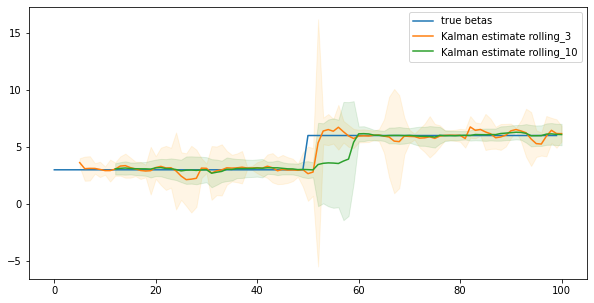

In [4]:
kf_3, confs_3 = KF(3).run('y', 'x', pd.DataFrame({'y': y1, 'x': x}))
kf_10, confs_10 = KF(10).run('y', 'x', pd.DataFrame({'y': y1, 'x': x}))

plt.figure(figsize=(10,5))
plt.plot(betas1, label='true betas')
plt.plot(kf_3, label='Kalman estimate rolling_3')
plt.fill_between(confs_3.index, confs_3['lower'], confs_3['upper'], alpha=0.1, color='orange')
plt.plot(kf_10, label='Kalman estimate rolling_10')
plt.fill_between(confs_10.index, confs_10['lower'], confs_10['upper'], alpha=0.1, color='green')
plt.legend()

Next we see how it deals with increasing variance.

In [5]:
betas2 = [i * np.random.normal(1, 10) for i in range(100)]
y2 = np.array(x) * np.array(betas2) + np.array([np.random.normal(0, 1) for i in range(len(x))])

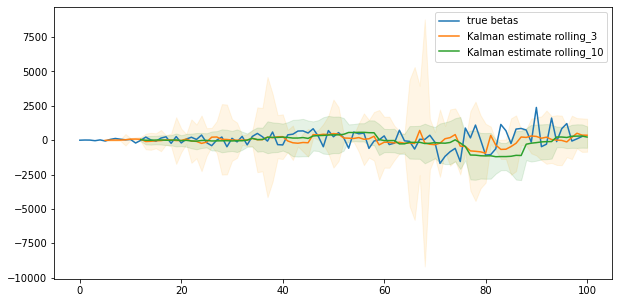

In [6]:
kf_3, confs_3 = KF(3).run('y', 'x', pd.DataFrame({'y': y2, 'x': x}))
kf_10, confs_10 = KF(10).run('y', 'x', pd.DataFrame({'y': y2, 'x': x}))

plt.figure(figsize=(10,5))
plt.plot(betas2, label='true betas')
plt.plot(kf_3, label='Kalman estimate rolling_3')
plt.fill_between(confs_3.index, confs_3['lower'], confs_3['upper'], alpha=0.1, color='orange')
plt.plot(kf_10, label='Kalman estimate rolling_10')
plt.fill_between(confs_10.index, confs_10['lower'], confs_10['upper'], alpha=0.1, color='green')
plt.legend()

Finally we simulate a trend.

In [7]:
betas3 = [100 + i + np.random.normal(1, 10) for i in range(100)]
y3 = np.array(x) * np.array(betas3) + np.array([np.random.normal(0, 1) for i in range(len(x))])

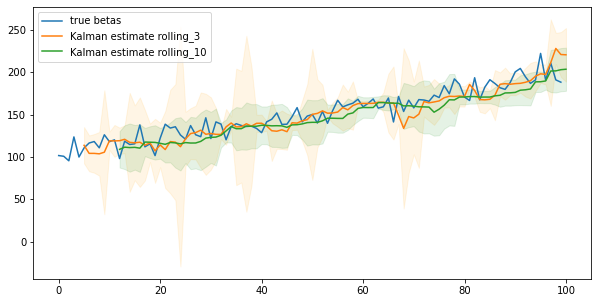

In [8]:
kf_3, confs_3 = KF(3).run('y', 'x', pd.DataFrame({'y': y3, 'x': x}))
kf_10, confs_10 = KF(10).run('y', 'x', pd.DataFrame({'y': y3, 'x': x}))

plt.figure(figsize=(10,5))
plt.plot(betas3, label='true betas')
plt.plot(kf_3, label='Kalman estimate rolling_3')
plt.fill_between(confs_3.index, confs_3['lower'], confs_3['upper'], alpha=0.1, color='orange')
plt.plot(kf_10, label='Kalman estimate rolling_10')
plt.fill_between(confs_10.index, confs_10['lower'], confs_10['upper'], alpha=0.1, color='green')
plt.legend()

It seems that the short term rolling window is far more prone to noise, and a longer-term measurement sample allows a better fit to the underlying trend.